Project goal is to build a text classifier for the news articles using  labeled dataset of 200.000 HuffPost articles in 41 different category.

There is a high probability, that some of the classes might be similar and overlaping, so the model will have a better accuracy 
if the prediction for more than one class will be compared to the true class.

Dataset is from - https://www.kaggle.com/rmisra/news-category-dataset/data

Structure of this notebook:

- Loading and inspecting data
- Data cleaning
- Modeling
- Evaluating the results.

In [23]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas_profiling as pp

# Loading Data

In [2]:
df = pd.read_json("News_Category_Dataset_v2.json", lines=True)

df.head()

category                                           headline  \
0          CRIME  There Were 2 Mass Shootings In Texas Last Week...   
1  ENTERTAINMENT  Will Smith Joins Diplo And Nicky Jam For The 2...   
2  ENTERTAINMENT    Hugh Grant Marries For The First Time At Age 57   
3  ENTERTAINMENT  Jim Carrey Blasts 'Castrato' Adam Schiff And D...   
4  ENTERTAINMENT  Julianna Margulies Uses Donald Trump Poop Bags...   

           authors                                               link  \
0  Melissa Jeltsen  https://www.huffingtonpost.com/entry/texas-ama...   
1    Andy McDonald  https://www.huffingtonpost.com/entry/will-smit...   
2       Ron Dicker  https://www.huffingtonpost.com/entry/hugh-gran...   
3       Ron Dicker  https://www.huffingtonpost.com/entry/jim-carre...   
4       Ron Dicker  https://www.huffingtonpost.com/entry/julianna-...   

                                   short_description       date  
0  She left her husband. He killed their children... 2018-05-26  
1                           Of course it has a song. 2018-05-26  
2  The actor and his longtime girlfriend Anna Ebe... 2018-05-26  
3  The actor gives Dems an ass-kicking for not fi... 2018-05-26  
4  The "Dietland" actress said using the bags is ... 2018-05-26

In [3]:
# Adding a zero column because of error when running PandasProfiling without it.
df['zero'] = 0

pp.ProfileReport(df, check_correlation=False)

C:\Users\Andrius\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


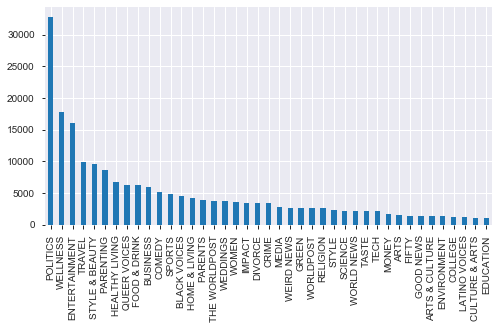

In [24]:
plt.figure(figsize=(8,4))

df['category'].value_counts().plot(kind='bar')
plt.show()

There is a heavy class imbalance towards politics, welness and entertainment, which may cause issues in predicting smaller categories.

# Data cleaning and preparation

In [5]:
df.link.sample(10).values

array(['https://www.huffingtonpost.com/entry/california-wine_us_5b9c9b7de4b03a1dcc80415e',
       'https://www.huffingtonpost.com/entry/david-schweikert-trump-investigation_us_594289b3e4b0d31854876fd6',
       'https://www.huffingtonpost.com/entry/athletic-combat-and-real-combat-more-alike-than-we-think_us_5baeb898e4b014374e2e7bbd',
       'https://www.huffingtonpost.com/entry/gisele-bundchen-tom-brady-california-home_us_5b9d7d92e4b03a1dcc88a761',
       'https://www.huffingtonpost.com/entry/lyfe-kitchen-change-how-america-eats_us_5b9d49a1e4b03a1dcc8653d8',
       'https://www.huffingtonpost.com/entry/pyrosome-philippines-video_n_6805644.html',
       'https://www.huffingtonpost.com/entry/dads-story-of-buying-sofia-the-first-dvd_us_5b9d0b33e4b03a1dcc83fcde',
       'https://www.huffingtonpost.com/entry/suffering-optional-walkin_b_5947766.html',
       'https://www.huffingtonpost.com/entry/britney-jamie-lynn-spears-surprise_us_56e9a060e4b0b25c91842d72',
       'https://www.huffingtonpos

In [6]:
# remove beginings and ends of the link,
# -, _ and the last part of the link, for example "us_59498b6de4b0177d0b8a3460" or "us_n_6362608"


def tokenize_url(url: str):
    url = url.replace("https://www.huffingtonpost.com/entry/", "")
    url = url.replace(".html", "")
    url = re.sub("(\W|_)+", " ", url)
    url = re.sub("...\w+$", "", url)
    return url

df['tokenized_url'] = [tokenize_url(url) for url in df['link']]

In [7]:
df['tokenized_url'].sample(5).values

array(['delta state university shooter left apology note before killings ',
       'spam gets a makeover ', 'the sea of galilee ',
       'donald trump american dreamer trucker hat ',
       'lana turner style photos '], dtype=object)

In [8]:
# Using all possible Data that is relevant to the topic.
# Concatenating description, headline and cleaned up URL in to one feature.

features = df["short_description"] + " " + df["headline"] + " "+ df['tokenized_url']
labels = df["category"]

In [9]:
features

0         She left her husband. He killed their children...
1         Of course it has a song. Will Smith Joins Dipl...
2         The actor and his longtime girlfriend Anna Ebe...
3         The actor gives Dems an ass-kicking for not fi...
4         The "Dietland" actress said using the bags is ...
                                ...                        
200848    Verizon Wireless and AT&T are already promotin...
200849    Afterward, Azarenka, more effusive with the pr...
200850    Leading up to Super Bowl XLVI, the most talked...
200851    CORRECTION: An earlier version of this story i...
200852    The five-time all-star center tore into his te...
Length: 200853, dtype: object

# Splitting and modeling

In [10]:
def modeling(data, labels):
    
    X = data
    y = labels
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.85)
    
    tfidf_vectorizer.fit_transform(X_train)

    

    X_train = tfidf_vectorizer.transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)

    LR = LogisticRegression(
    verbose=1, solver='saga', random_state=0, C=5, max_iter=1000, n_jobs=-1)

    model = LR.fit(X_train, y_train)

    
    return model, X_test, y_test

In [11]:
model, X_test, y_test = modeling(features, labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 39 epochs took 49 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   49.7s finished


# Evaluating the Model


In [12]:
def model_eval(X_test, y_test):
    
    probs = model.predict_proba(X_test)

    class_positions = np.argsort(probs, axis=1)[:,-2:]
    y_pred = [[model.classes_[cl] for cl in cls] for cls in list(class_positions)]
    

    matching_classes = []
    for y_pr, y_tr in zip(y_pred, list(y_test)):
    
        if y_tr in y_pr:
            matching_classes.append(y_tr)
        else:
            matching_classes.append(y_pr[0])
            
    print(classification_report(y_test, matching_classes))

## Step by step

In [13]:
probs = model.predict_proba(X_test)

# Sorting predictions and taking the index number of two highest probabilities to reference a specific news class.

class_positions = np.argsort(probs, axis=1)[:,-2:]
class_positions

array([[ 6, 24],
       [24, 20],
       [29, 30],
       ...,
       [ 2, 10],
       [22, 37],
       [20, 10]], dtype=int64)

In [14]:
# Making a list with names to compare with the y_test/ground truth.

y_pred = [[model.classes_[cl] for cl in cls] for cls in list(class_positions)]
y_pred

[['CRIME', 'POLITICS'],
 ['POLITICS', 'MEDIA'],
 ['STYLE', 'STYLE & BEAUTY'],
 ['DIVORCE', 'PARENTING'],
 ['BLACK VOICES', 'POLITICS'],
 ['ENTERTAINMENT', 'POLITICS'],
 ['BLACK VOICES', 'ENTERTAINMENT'],
 ['COMEDY', 'SPORTS'],
 ['WORLDPOST', 'QUEER VOICES'],
 ['ENVIRONMENT', 'GREEN'],
 ['POLITICS', 'SPORTS'],
 ['WORLDPOST', 'IMPACT'],
 ['ENTERTAINMENT', 'COMEDY'],
 ['LATINO VOICES', 'POLITICS'],
 ['LATINO VOICES', 'POLITICS'],
 ['THE WORLDPOST', 'SPORTS'],
 ['BUSINESS', 'POLITICS'],
 ['GREEN', 'POLITICS'],
 ['HEALTHY LIVING', 'WELLNESS'],
 ['PARENTING', 'WELLNESS'],
 ['FOOD & DRINK', 'TASTE'],
 ['POLITICS', 'MEDIA'],
 ['BLACK VOICES', 'POLITICS'],
 ['HEALTHY LIVING', 'BUSINESS'],
 ['STYLE & BEAUTY', 'WEDDINGS'],
 ['COLLEGE', 'IMPACT'],
 ['BLACK VOICES', 'SPORTS'],
 ['WOMEN', 'FOOD & DRINK'],
 ['POLITICS', 'QUEER VOICES'],
 ['STYLE', 'STYLE & BEAUTY'],
 ['COMEDY', 'ENTERTAINMENT'],
 ['WOMEN', 'ENTERTAINMENT'],
 ['HEALTHY LIVING', 'POLITICS'],
 ['FOOD & DRINK', 'WELLNESS'],
 ['POLITICS',

In [15]:
# If one of the two predicted classes matches a true class, then we consider it as a correct prediction
# and add the True class to the list. If there is no match - adding the main class that was predicted.

matching_classes = []

for y_pr, y_tr in zip(y_pred, list(y_test)):
    
    if y_tr in y_pr:
        matching_classes.append(y_tr)
    else:
        matching_classes.append(y_pr[0]) 
    

In [16]:
print(classification_report(y_test, matching_classes))

                precision    recall  f1-score   support

          ARTS       0.55      0.38      0.45       359
ARTS & CULTURE       0.65      0.39      0.49       355
  BLACK VOICES       0.72      0.72      0.72      1113
      BUSINESS       0.68      0.71      0.69      1427
       COLLEGE       0.76      0.52      0.62       292
        COMEDY       0.69      0.67      0.68      1325
         CRIME       0.79      0.77      0.78       788
CULTURE & ARTS       0.69      0.43      0.53       268
       DIVORCE       0.90      0.84      0.87       883
     EDUCATION       0.71      0.54      0.61       237
 ENTERTAINMENT       0.80      0.89      0.84      3937
   ENVIRONMENT       0.64      0.46      0.53       343
         FIFTY       0.57      0.36      0.44       342
  FOOD & DRINK       0.86      0.89      0.88      1569
     GOOD NEWS       0.62      0.38      0.47       341
         GREEN       0.68      0.64      0.66       642
HEALTHY LIVING       0.59      0.67      0.63  

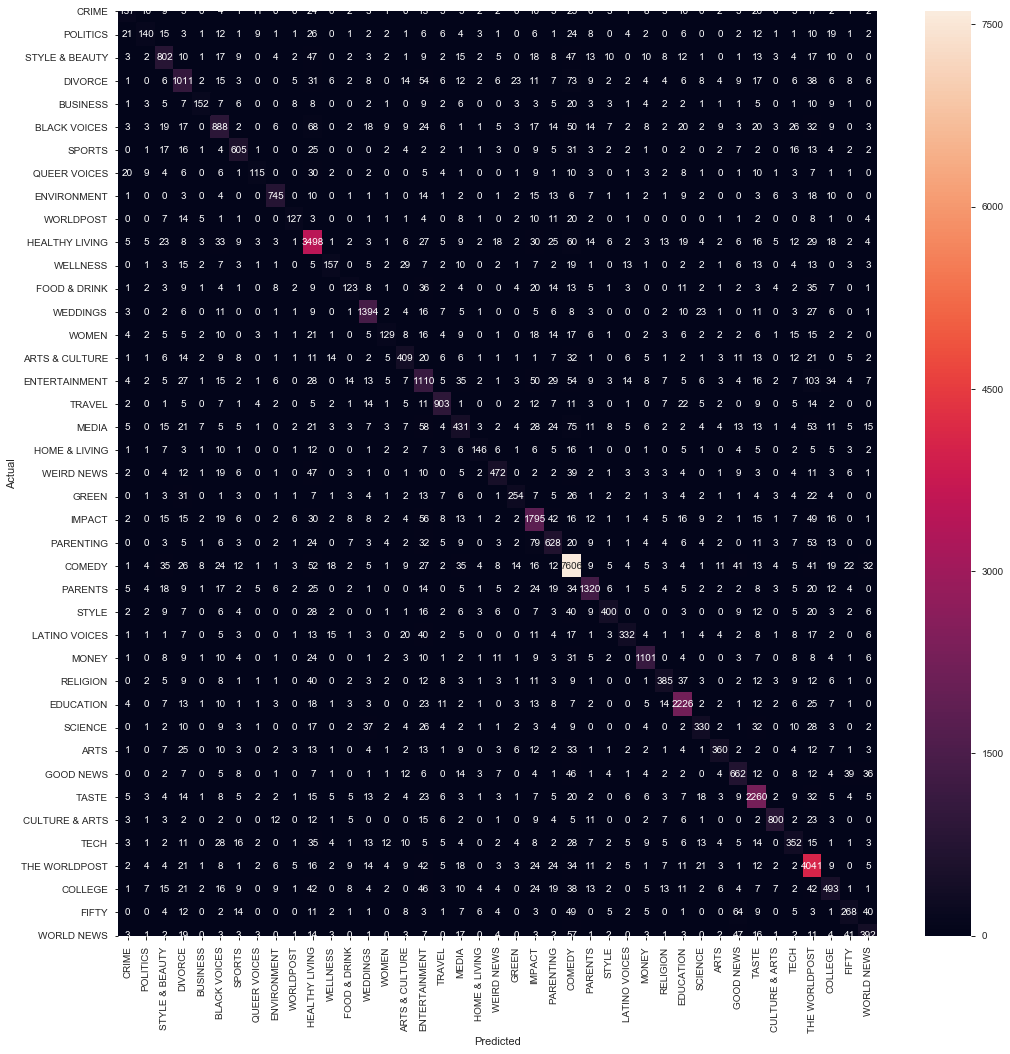

In [25]:
conf_mat = confusion_matrix(y_test, matching_classes)
fig, ax = plt.subplots(figsize=(17,17))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=y_test.unique(), yticklabels=y_test.unique()
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Balancing Dataset with Oversampling

ADASYN generates samples of the minority class according to their density distributions.

In [18]:
from imblearn.over_sampling import RandomOverSampler, ADASYN


def modeling_balanced(data, labels):
     
    X = data
    y = labels
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    tfidf_vectorizer = TfidfVectorizer(max_df=0.85, stop_words="english")
    
    tfidf_vectorizer.fit_transform(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)
    
#     rus = RandomOverSampler(random_state=42)
#     X_train, y_train = rus.fit_resample(X_train, y_train)

    oversampler = ADASYN(random_state=42)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)

    LR = LogisticRegression(
    verbose=1, solver='saga', random_state=0, C=5, max_iter=1000, n_jobs=-1)

    model = LR.fit(X_train, y_train)

    
    return model, X_test, y_test

Using TensorFlow backend.
C:\Users\Andrius\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Andrius\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Andrius\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Andrius\Anaconda3\lib\site-packages\tensorflow\python\framework\d

In [19]:
model, X_test, y_test = modeling_balanced(features, labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 38 epochs took 496 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  8.3min finished


In [20]:
model_eval(X_test, y_test)

                precision    recall  f1-score   support

          ARTS       0.37      0.50      0.43       359
ARTS & CULTURE       0.55      0.48      0.51       355
  BLACK VOICES       0.69      0.73      0.71      1113
      BUSINESS       0.68      0.69      0.68      1427
       COLLEGE       0.65      0.60      0.62       292
        COMEDY       0.59      0.70      0.64      1325
         CRIME       0.75      0.76      0.75       788
CULTURE & ARTS       0.57      0.52      0.55       268
       DIVORCE       0.87      0.85      0.86       883
     EDUCATION       0.54      0.60      0.57       237
 ENTERTAINMENT       0.84      0.84      0.84      3937
   ENVIRONMENT       0.59      0.55      0.57       343
         FIFTY       0.38      0.43      0.40       342
  FOOD & DRINK       0.85      0.84      0.85      1569
     GOOD NEWS       0.49      0.46      0.47       341
         GREEN       0.64      0.66      0.65       642
HEALTHY LIVING       0.56      0.66      0.60  

# Conclusions

Classification task results were quite good knowing that were high number of classes that has relatively small amount of samples.

Using oversampling adds a significant amount of computing time and does not help to achieve better results.